# Simple speech recognition system

we will be implementing in this notebook a simple system for speech recognizing of isolated words 
based on a parameterization of the speech signal using LPC coefficients, and a
recognition by the classification algorithm of the nearest k neighbours based on the
elastic distance between parameterized signals.


In [2]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt 
from scipy.linalg import toeplitz
from numpy.linalg import inv
import os


Defining the function <b>generate_name(c,n,i)</b> to generate the names of the audio files 

In [3]:
loc = ['jackson', 'jason', 'nicolas','theo']
def generate_name(c,n,i):
    return(str(c) +'_'+loc[n]+'_'+str(i)+'.wav' )

Let's first  display some audio files

C:\Users\D92979\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


0

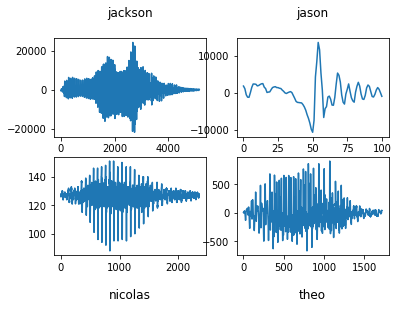

In [4]:
signal1 = wav.read("spoken_digit_dataset/"+generate_name(0,0,0))
signal2 = wav.read("spoken_digit_dataset/"+generate_name(1,1,0))
signal3 = wav.read("spoken_digit_dataset/"+generate_name(1,2,4))
signal4 = wav.read("spoken_digit_dataset/"+generate_name(1,3,4))

plt.subplot(221)
plt.plot(signal1[1])
plt.title('jackson\n  ')
plt.subplot(222)
plt.plot(signal2[1])
plt.title('jason\n  ')
plt.subplot(223)
plt.plot(signal3[1][:,0])
plt.title('nicolas',y=-0.5)
plt.subplot(224)
plt.plot(signal4[1])
plt.title('theo',y=-0.5)
0

## I) Audio data parametrization using LPC coefficients

We divide the audio signal into several frames of 20ms, which is equivalent to taking a frame of size $\frac{Fe}{50}$ and for each frame we calculate the autocovariance matrix of order $N = 8$.
   
the function <b>R = mat_autocov(frame,N)</b> takes as input a <b>frame</b> and the coefficient <b>N</b> and returns the autocovariance matrix <b>R</b>.

In [5]:
def mat_autocov(trame,N):
    len_trame = len(trame)
    R = []
    for i in range(N + 1):
        t1 = trame[0:len_trame - i]
        t2 = trame[i:len_trame]
        ri = np.mean(t1*t2)
        R.append(ri)
    return toeplitz(R)

we then define the function <b>LPC_mat = LPC_coef(signal, N)</b> which takes as input a signal = (Fe,s) audio and returns the matrix of the LPC coefficients, <b>LPC_mat</b>

In [6]:
def LPC_coef(signal, N):
    (Fe,s) = signal
    vect = np.zeros([N+1,1])
    vect[0] = 1
    len_trame = int(Fe/50)
    
    LPC_mat = np.zeros([N+1,0])
    
    debut = 0
    fin = len_trame
    pas = int(len_trame/2)
    while fin < len(s):

        trame = s[debut:fin]
        R = mat_autocov(trame,N)
        coef = np.dot(inv(R),vect)
        coef = coef/coef[0]
        LPC_mat = np.hstack((LPC_mat,coef))
        debut +=  pas
        fin += pas
    
    return LPC_mat

### Optional :
The LPC coefficients are calculated for each file and saved in the file <b>LPC</b> for quick reuse

In [7]:
if not os.path.exists("LPC"):
    os.makedirs("LPC")
for c in range(0,10):
    for n in range(0,4):
        for i in range(0,50):
            signal = wav.read("spoken_digit_dataset/"+generate_name(c,n,i))
            lpc_mat = LPC_coef(signal, 8)
            file_name = "LPC/LPC_"+generate_name(c,n,i).replace("wav","npy")
            np.save(file_name, lpc_mat)

We define the function <b>D = distance (LPC_mat1,LPC_mat2)</b> which takes as input two LPC matrices and returns the distance D.<br>
To calculate the distance between two frames, the following formula is used:
$$dist(v_1,v_2) = \frac{1}{2}\left(1 - \frac{v_1 . v_2}{||v_1||\times||v_2||}\right)$$

In [8]:
def distance(LPC_mat1,LPC_mat2):
    n = len(LPC_mat1)
    m = len(LPC_mat2)
    g = np.zeros([m,n])
    for j in range(1,n):
        for i in range(1,m):
            try :
                dij =0.5*(1 - np.dot(LPC_mat1[:,i] , LPC_mat2[:,j])/(np.linalg.norm(LPC_mat1[:,i])*np.linalg.norm(LPC_mat2[:,j])))
                #dij = np.linalg.norm(LPC_mat1[:,i] - LPC_mat2[:,j])/np.linalg.norm(LPC_mat1[:,i] + LPC_mat2[:,j])
            except :
                # dans le cas ou la matrice LPC est vide dij = 1, cela peut  se produire quand le signal est inferieur à fe/50
                dij = 1
            g[i, j] = round(min([g[i-1, j] + 2*dij,g[i, j-1] + 2*dij, g[i-1, j-1] + dij]),3)
            
    return round(g[m-1,n-1]/(n+m),4)
    

The distance matrix is calculated and displayed. <br>
We just take a $10$ sample instead of $50$.

In [7]:
cMax = 10
iMax = 4
nMax = 10
mat = np.zeros([cMax*iMax*nMax,cMax*iMax*nMax])

for c1 in range(0,cMax):
    for n1 in range(0,iMax):
        for i1 in range(0,nMax):
            for c2 in range(0,cMax):
                for n2 in range(0,iMax):
                    for i2 in range(0,nMax):
                        file_name1 = "LPC/LPC_"+generate_name(c1,n1,i1).replace("wav","npy")
                        file_name2 = "LPC/LPC_"+generate_name(c2,n2,i2).replace("wav","npy")

                        LPC_mat1 = np.load(file_name1)
                        LPC_mat2 = np.load(file_name2)
                        
                        D = distance(LPC_mat1,LPC_mat2)
                        mat[c1*iMax*nMax + n1*nMax + i1 , c2*iMax*nMax + n2*nMax + i2] = D

    

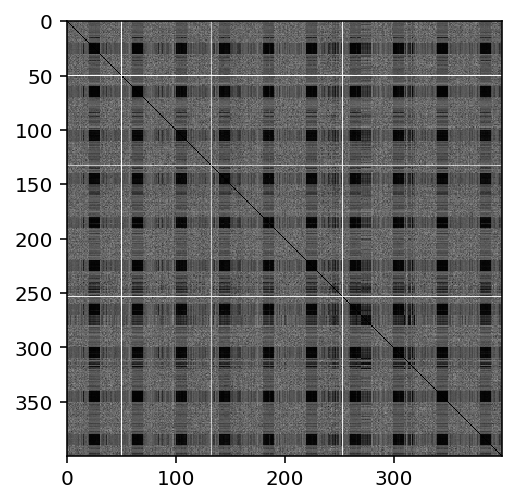

In [8]:
imgplot = plt.imshow(mat, cmap='gray')

In [9]:
np.save("matrice_distance_10.npy", mat)